In [1]:
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom

# Exercise 1

(998, 800)
uint8


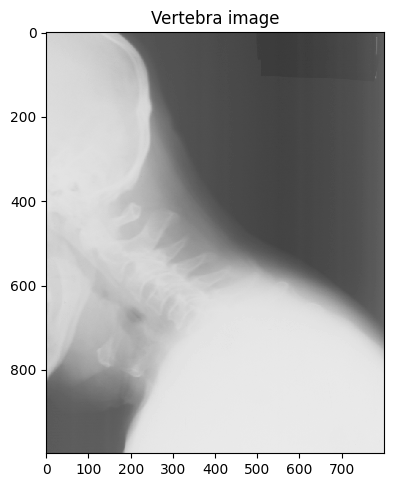

In [2]:
# Read vertebra.png
in_dir = "data/"
im_name = "vertebra.png"
im_org = io.imread(in_dir + im_name)

# Print image dimensions
print(im_org.shape)
print(im_org.dtype)

# Show image
io.imshow(im_org)
plt.title('Vertebra image')
io.show()

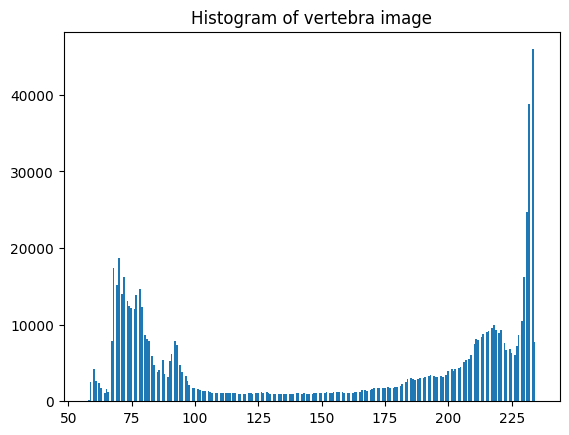

In [3]:
# Show histogram of image
h = plt.hist(im_org.ravel(), bins=256)
plt.title('Histogram of vertebra image')
plt.show()

This is bimodal, since the histogram is split in two peaks. It should be possible to segment it so only the bones are visible.

# Exercise 2

In [4]:
# Maximum value in image
max_val = im_org.max()
print(f"Maximum value in image: {max_val}")

# Minimum value in image
min_val = im_org.min()
print(f"Minimum value in image: {min_val}")

Maximum value in image: 235
Minimum value in image: 57


The full scale of the spectrum isn't used. We can do histogram stretching

# Exercise 3

In [5]:
from skimage.util import img_as_float
from skimage.util import img_as_ubyte

In [6]:
im_float = img_as_float(im_org)

# Maximum value in image
max_val = im_float.max()
print(f"Maximum value in image: {max_val} * 255 = {max_val * 255}")

# Minimum value in image
min_val = im_float.min()
print(f"Minimum value in image: {min_val} * 255 = {min_val * 255}")

print("This matches the previous exercise max & min values")

Maximum value in image: 0.9215686274509803 * 255 = 235.0
Minimum value in image: 0.22352941176470587 * 255 = 56.99999999999999
This matches the previous exercise max & min values


# Exercise 4

In [7]:
im_byte = img_as_ubyte(im_float)

# Maximum value in image
max_val = im_byte.max()
print(f"Maximum value in image: {max_val}")

# Minimum value in image
min_val = im_byte.min()
print(f"Minimum value in image: {min_val}")

print("This is as expected")

Maximum value in image: 235
Minimum value in image: 57
This is as expected


# Exercise 5

In [8]:
def histogram_stretch(img_in, vmax_default=1.0, vmin_default=0.0):
    # Convert to float
    img_in = img_as_float(img_in.copy())

    # Find min and max
    vmax = img_in.max()
    vmin = img_in.min()
    
    # Compute gain
    gain = (vmax_default - vmin_default) / (vmax - vmin)

    return img_as_ubyte((img_in - vmin) * gain + vmin_default)

# Exercise 6

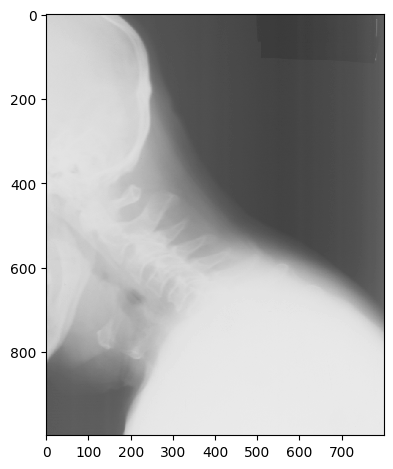

In [9]:
# Show image before stretching
io.imshow(im_org)
io.show()

Min value: 0
Max value: 255


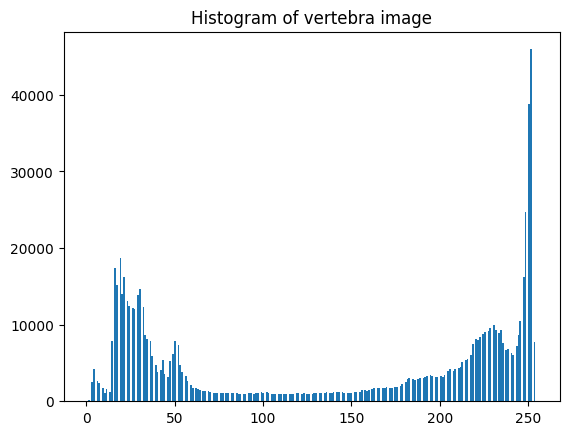

In [10]:
# Test histogram stretching on vertebra image
im_stretched = histogram_stretch(im_org)

# Print max and min values of image
print(f"Min value: {im_stretched.min()}")
print(f"Max value: {im_stretched.max()}")

# Show histogram of image
h = plt.hist(im_stretched.ravel(), bins=256)
plt.title('Histogram of vertebra image')
plt.show()

The important structures are more visible, the dark areas are darker and the bright areas are brighter


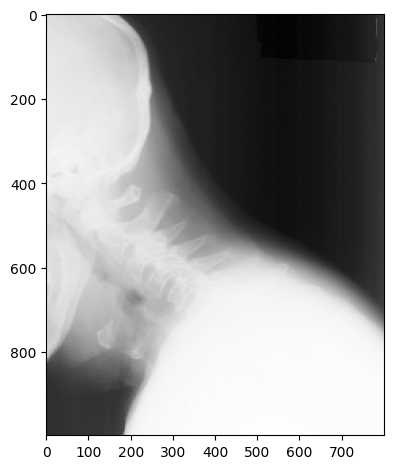

In [11]:
# Show image after histogram stretching
io.imshow(im_stretched)

print("The important structures are more visible, the dark areas are darker and the bright areas are brighter")

# Exercise 7

In [12]:
def gamma_map(img, gamma):
    img_float = img_as_float(img.copy())
    return img_as_ubyte(img_float ** gamma)

# Exercise 8

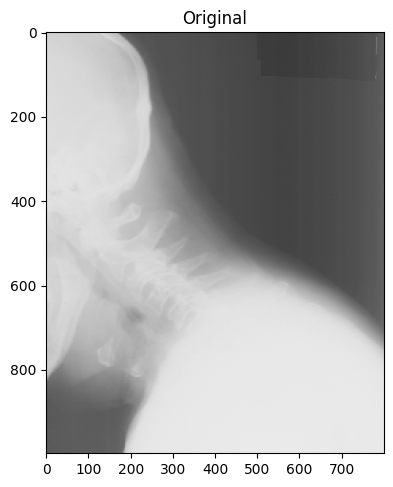

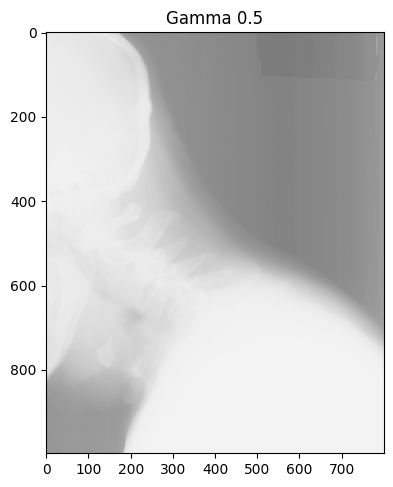

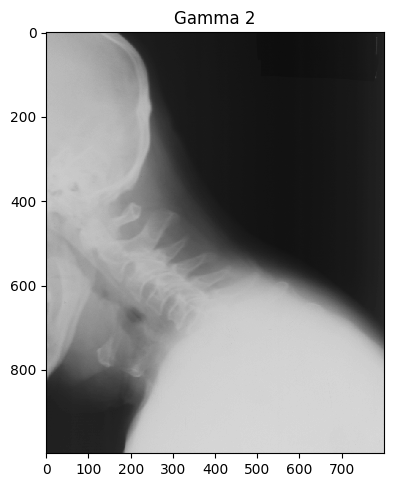

In [13]:
# Test gamma mapping
gamma1 = gamma_map(im_org, 0.5)
gamma2 = gamma_map(im_org, 2)

# Show all three images
io.imshow(im_org)
plt.title('Original')
io.show()
io.imshow(gamma1)
plt.title('Gamma 0.5')
io.show()
io.imshow(gamma2)
plt.title('Gamma 2')
io.show()


# Exercise 9

In [14]:
def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """
    img_in = img_as_ubyte(img_in.copy())
    img_in[img_in < thres] = 0
    img_in[img_in >= thres] = 255
    return img_in

# Exercise 10

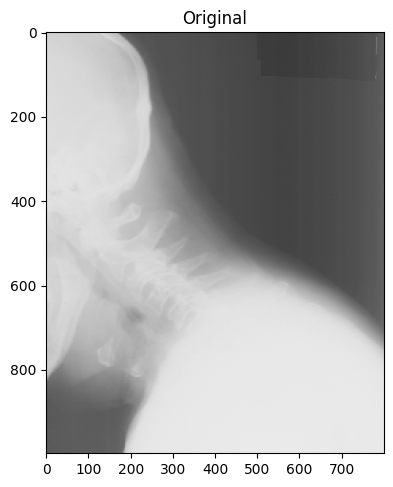

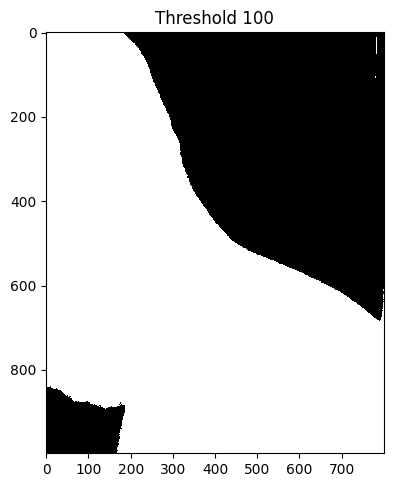

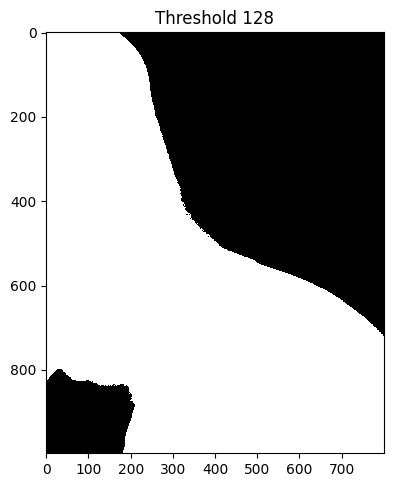

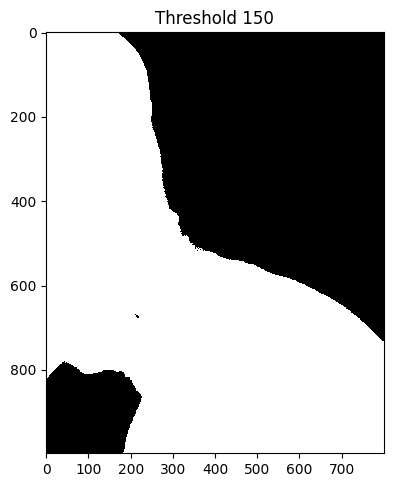

In [15]:
# Test function for thresholding
threshold1 = threshold_image(im_org, 100)
threshold2 = threshold_image(im_org, 128)
threshold3 = threshold_image(im_org, 150)

# Show all three images
io.imshow(im_org)
plt.title('Original')
io.show()
io.imshow(threshold1)
plt.title('Threshold 100')
io.show()
io.imshow(threshold2)
plt.title('Threshold 128')
io.show()
io.imshow(threshold3)
plt.title('Threshold 150')
io.show()

# Exercise 11

In [16]:
from skimage.filters import threshold_otsu

Otsu threshold: 148


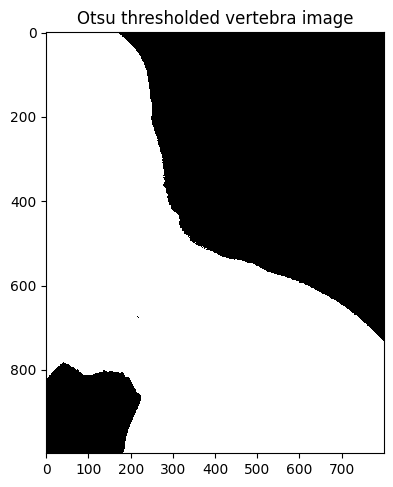

In [17]:
otsu = threshold_otsu(im_org)
print(f"Otsu threshold: {otsu}")
img_otsu = threshold_image(im_org, otsu)
io.imshow(img_otsu)
plt.title('Otsu thresholded vertebra image')
io.show()

It is very close to my experimentation with 150 as a threshold value

# Exercise 12

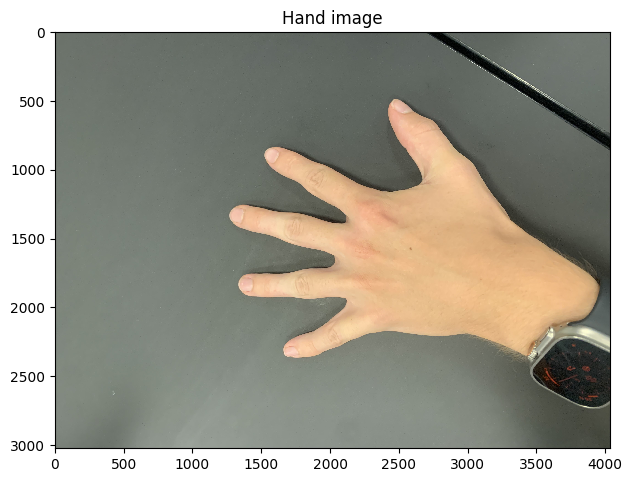

In [18]:
# Load image
in_dir = "data/"
im_name = "Photo 24-09-2024, 09.03.41.jpg"
im_hand = io.imread(in_dir + im_name)
io.imshow(im_hand)
plt.title('Hand image')
io.show()

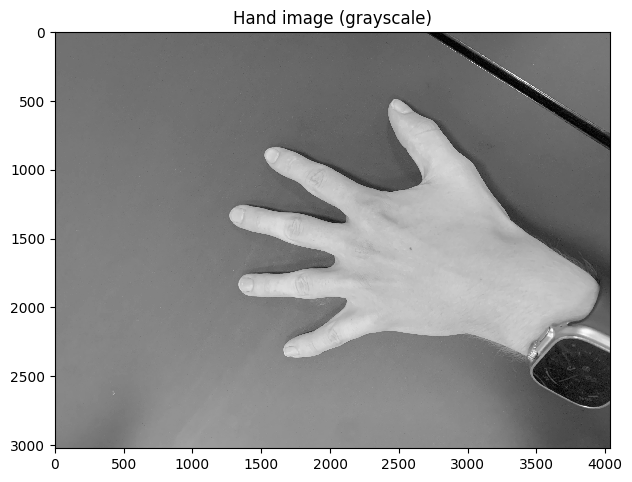

In [19]:
# Conver to grayscale
im_hand_grey = color.rgb2gray(im_hand)
im_hand_grey = img_as_ubyte(im_hand_grey)
io.imshow(im_hand_grey)
plt.title('Hand image (grayscale)')
io.show()

Threshold: 151


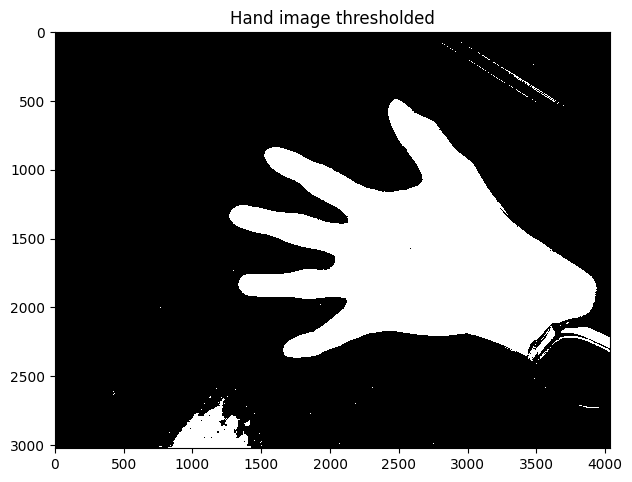

In [20]:
threshold = threshold_otsu(im_hand_grey)
print(f"Threshold: {threshold}")
im_hand_thresh = threshold_image(im_hand_grey, threshold)
io.imshow(im_hand_thresh)
plt.title('Hand image thresholded')
io.show()

# Exercise 13

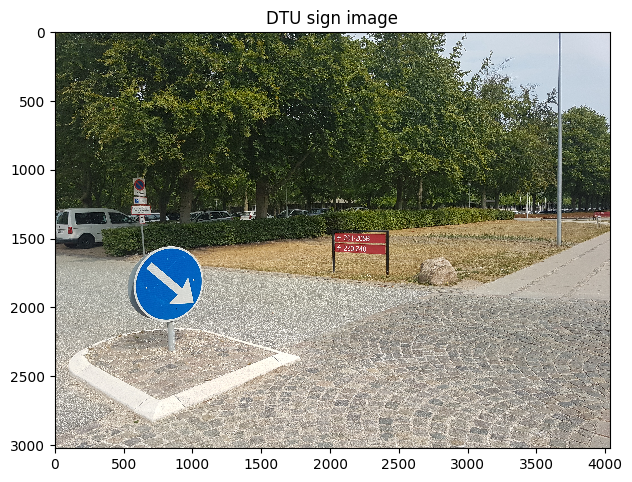

In [21]:
# Load sign image
in_dir = "data/"
im_name = "DTUSigns2.jpg"
im_sign = io.imread(in_dir + im_name)
io.imshow(im_sign)
plt.title('DTU sign image')
io.show()

In [22]:
def detect_dtu_signs(im_org, color='blue'):
    r_comp = im_org[:, :, 0]
    g_comp = im_org[:, :, 1]
    b_comp = im_org[:, :, 2]

    if color == 'blue':
        segm = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
                    (b_comp > 180) & (b_comp < 200)
    elif color == 'red':
        segm = (r_comp > 150) & (g_comp < 85) & (b_comp < 85)
    else:
        raise ValueError("Color must be 'blue' or 'red'")
    
    return segm

# Exercise 14

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
from IPython.display import display

def plot_image_with_zoom(image_path, zoom_factor=10):
    # Load the image
    img = plt.imread(image_path)
    
    def plot_zoomed(x, y):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot the full image
        ax1.imshow(img)
        ax1.set_title('Full Image')
        
        # Calculate the zoom window
        height, width = img.shape[:2]
        x, y = int(x * width), int(y * height)
        zoom_size = min(width, height) // zoom_factor
        x1, x2 = max(0, x - zoom_size // 2), min(width, x + zoom_size // 2)
        y1, y2 = max(0, y - zoom_size // 2), min(height, y + zoom_size // 2)
        
        # Plot the zoomed region
        ax2.imshow(img[y1:y2, x1:x2])
        ax2.set_title('Zoomed Region')
        
        # Add a rectangle to show the zoomed area on the full image
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, ec='r')
        ax1.add_patch(rect)
        
        # Display RGB values
        if len(img.shape) == 3:  # Color image
            rgb = img[y, x]
            ax2.set_xlabel(f'RGB at ({x}, {y}): {rgb}')
        else:  # Grayscale image
            gray = img[y, x]
            ax2.set_xlabel(f'Grayscale at ({x}, {y}): {gray}')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive plot
    interactive_plot = interactive(plot_zoomed, 
                                   x=(0, 1, 0.01), 
                                   y=(0, 1, 0.01))
    
    display(interactive_plot)

# Usage
image_path = in_dir + im_name
plot_image_with_zoom(image_path)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, step=0.01), FloatSlider(value=0.0, desc…

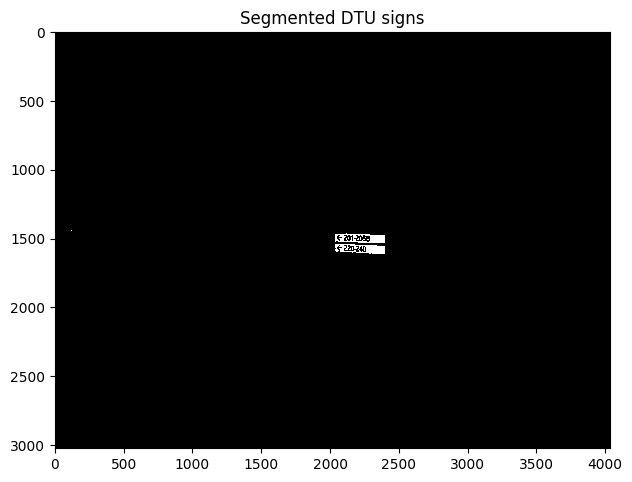

In [24]:
# Segment DTU signs
im_segmented = detect_dtu_signs(im_sign,"red")
io.imshow(im_segmented)
plt.title('Segmented DTU signs')
io.show()

# Exercise 15

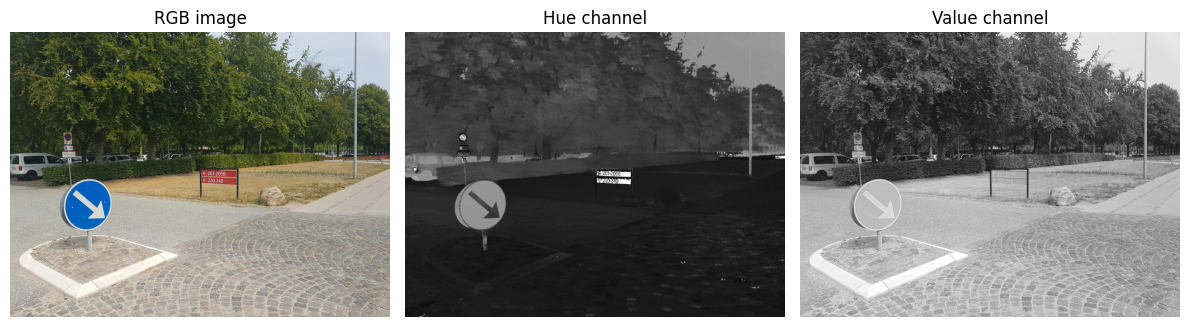

In [25]:
hsv_img = color.rgb2hsv(im_sign)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
ax0.imshow(im_sign)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='grey')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img, cmap='grey')
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()
io.show()

In [26]:
# Print shapes of hue and value channels
print(hue_img.shape)
print(value_img.shape)

# Print dtypes of hue and value channels
print(hue_img.dtype)
print(value_img.dtype)

# Print range of hue and value channels
print(hue_img.min())
print(hue_img.max())

print(value_img.min())
print(value_img.max())

(3024, 4032)
(3024, 4032)
float64
float64
0.0
0.9986111111111111
0.0
1.0


In [27]:
# Segmentation function in HSV space
def detect_dtu_signs_hsv(im_org):
    hsv_img = color.rgb2hsv(im_org.copy())
    hue_img = hsv_img[:, :, 0]
    value_img = hsv_img[:, :, 2]

    # Create binary image from the hue image
    segm = (hue_img > 0.5) & (value_img > 0.5) & (value_img < 0.8)

    return img_as_ubyte(segm)

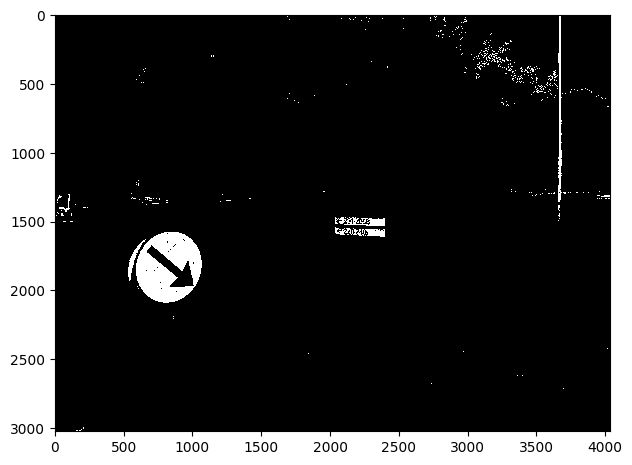

In [28]:
im_segm_hue = detect_dtu_signs_hsv(im_sign)
io.imshow(im_segm_hue)
io.show()

# Exercise 16
Works as intended

# Exercise 17
Added the gamma mapping function from the notebook

# Exercise 18
Done but only runs at 5fps